<h2>Lista 04</h2>
<br>
Apresentação criada por <b>Francisca Beatriz Precebes da Silva</b>. Aqui serão analisados os dados encontrados <a href='https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'> neste dataset </a>.

<h3>Definindo bibliotecas</h3>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


<h3>Modelos</h3>

<b>Perceptron</b>

In [2]:
class Perceptron(object):
    """Perceptron classifier.
    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.
    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.
        Returns
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

<b>Adaline com  Gradiente Descentente<b>

In [3]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.
    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.
    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.
        Returns
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

<b>Adaline com  Gradiente Descentente Estocástico</b>

In [4]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.
    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.
    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training samples in each epoch.
        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.
        Returns
        -------
        self : object
        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)


In [5]:
coluns = ['ID','diagnosis','radius','texture', 'perimeter','area','smoothness','compactness','concavity',
           'concave_points','symmetry','fractal_dimension', 'radiusSE','textureSE','perimeterSE','areaSE',
           'smoothnessSE','compactenessSE','concavitySE','concave_pointsSE','symmetrySE','fractal_dimensionSE',
           'radiusW','textureSW','perimeterW','areaW','smoothnessW','compactnessW','concavityW','concave_pointsW',
           'symmetryW','fractal_dimensionW']
df = pd.read_csv('wdbc.data', names=coluns)

<h3>Visuaização e descrição dos dados</h3>

In [6]:
df.head()

,ID,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,...,radiusW,textureSW,perimeterW,areaW,smoothnessW,compactnessW,concavityW,concave_pointsW,symmetryW,fractal_dimensionW
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
ID                     569 non-null int64
diagnosis              569 non-null object
radius                 569 non-null float64
texture                569 non-null float64
perimeter              569 non-null float64
area                   569 non-null float64
smoothness             569 non-null float64
compactness            569 non-null float64
concavity              569 non-null float64
concave_points         569 non-null float64
symmetry               569 non-null float64
fractal_dimension      569 non-null float64
radiusSE               569 non-null float64
textureSE              569 non-null float64
perimeterSE            569 non-null float64
areaSE                 569 non-null float64
smoothnessSE           569 non-null float64
compactenessSE         569 non-null float64
concavitySE            569 non-null float64
concave_pointsSE       569 non-null float64
symmetrySE        

In [8]:
df.describe()

,ID,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,...,radiusW,textureSW,perimeterW,areaW,smoothnessW,compactnessW,concavityW,concave_pointsW,symmetryW,fractal_dimensionW
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


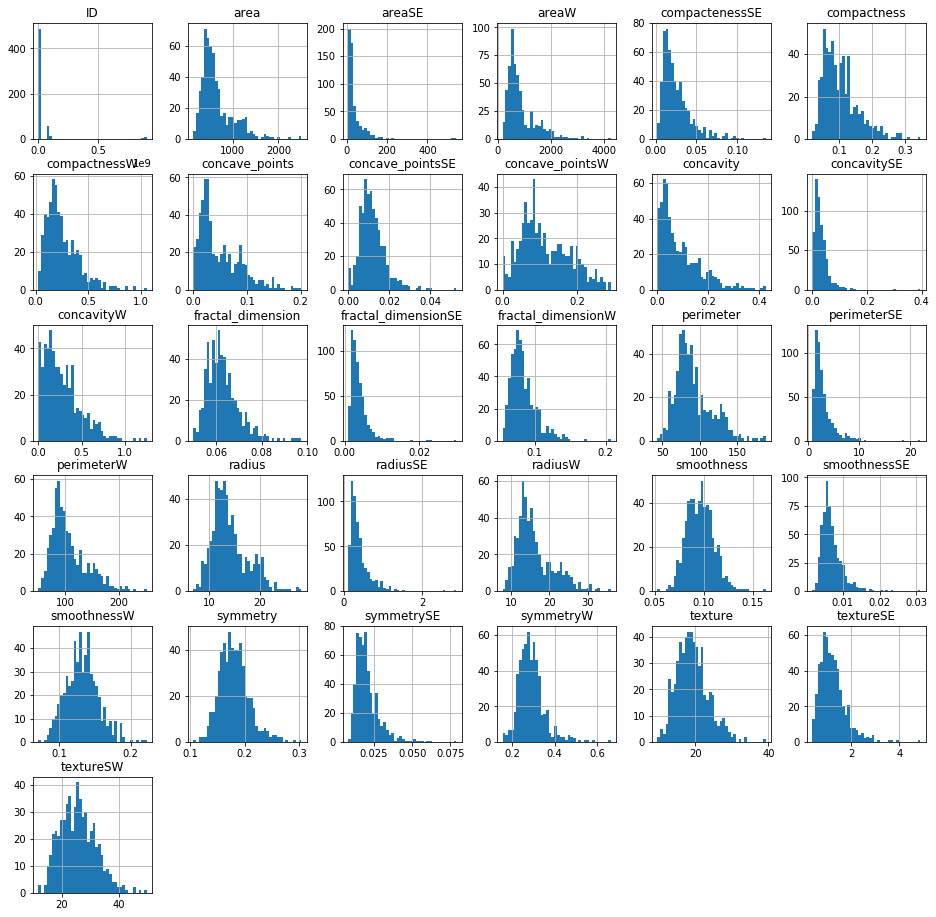

In [9]:
df.hist(bins=40, figsize=(16,16));

In [10]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

<h3>Seperação entre features e label</h3>

In [11]:
X = df.values[:, :-1]
y = df.values[:, -1]

<h3>Randomização dos dados usando semente (seed)</h3>

In [12]:
rs = np.random.RandomState(1)
shuffled_indices = rs.permutation(X.shape[0])
shuffled_indices

array([421,  47, 292, 186, 414, 132, 161, 197, 245, 453, 411, 214, 283,
       107, 542, 518, 324, 488, 376, 237, 362, 420, 451, 519,  65, 242,
       558,  85, 180, 207, 564, 342,  17, 435,  66, 326, 274,  90,  41,
       187, 520,  49, 160, 124, 221, 257, 539, 273, 486,  29, 492,   0,
       111, 285, 424, 477, 195, 277, 378, 547, 159,   9, 147,  92, 246,
       286, 480, 233, 189, 399, 179,  69,  40, 432, 358, 258,  38, 135,
       304,  34,  67, 335, 308, 370, 403, 120, 501, 545,  62, 344, 457,
        31, 555, 443, 400,   5,  59, 496, 289, 346, 531, 305, 425, 347,
       462, 165, 550, 295, 119, 172,   3,  68, 448, 442, 408,   4, 307,
       386, 404, 434,  19, 517, 535, 445, 554, 236, 117, 157, 162,  78,
       409, 484, 334,  42, 173, 223, 201, 133, 232, 413, 514, 244, 415,
       562, 291,  16, 546, 293, 350, 392, 102, 551, 225, 146, 447, 306,
       128, 247, 483, 110, 439, 284, 410, 329, 142, 407,   6, 487,  11,
       268, 419, 249,  58, 476, 529, 422, 192, 527, 472, 101, 54

In [13]:
X = X[shuffled_indices]
y = y[shuffled_indices]

In [14]:
X[:7]

array([[906564, 'B', 14.69, 13.98, 98.22, 656.1, 0.1031, 0.1836, 0.145,
        0.063, 0.2086, 0.07406, 0.5462, 1.511, 4.795, 49.45, 0.009976,
        0.05244, 0.05278, 0.0158, 0.02653, 0.005444, 16.46, 18.34, 114.1,
        809.2, 0.1312, 0.3635, 0.3219, 0.1108, 0.2827],
       [85715, 'M', 13.17, 18.66, 85.98, 534.6, 0.1158, 0.1231, 0.1226,
        0.0734, 0.2128, 0.06777, 0.2871, 0.8937, 1.897, 24.25, 0.006532,
        0.02336, 0.02905, 0.01215, 0.01743, 0.003643, 15.67, 27.95,
        102.8, 759.4, 0.1786, 0.4166, 0.5006, 0.2088, 0.39],
       [891670, 'B', 12.95, 16.02, 83.14, 513.7, 0.1005, 0.07943,
        0.06155, 0.0337, 0.173, 0.0647, 0.2094, 0.7636, 1.231, 17.67,
        0.008725, 0.02003, 0.02335, 0.01132, 0.02625, 0.004726, 13.74,
        19.93, 88.81, 585.4, 0.1483, 0.2068, 0.2241, 0.1056, 0.338],
       [874217, 'M', 18.31, 18.58, 118.6, 1041.0, 0.08588, 0.08468,
        0.08169, 0.05814, 0.1621, 0.05425, 0.2577, 0.4757, 1.817, 28.92,
        0.002866, 0.009181, 0.01412,

In [19]:
y[:7]

array([0.09208, 0.1179, 0.09584, 0.06938, 0.06165, 0.07619, 0.06251],
      dtype=object)

In [16]:
n_train = int(round(len(y) * 0.7))
X_train = X[:n_train,:]
y_train = y[:n_train]
X_test = X[n_train:,:]
y_test = y[n_train:]

In [17]:
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((569, 31), (569,), (398, 31), (398,), (171, 31), (171,))

In [18]:
model = Perceptron(eta=0.00001, n_iter=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = sum(y_pred == y_test) / y_test.shape[0]
accuracy

TypeError: can't multiply sequence by non-int of type 'float'